# Drizzling WFPC2 Images to use a Single Zeropoint

<div class="alert alert-block alert-warning" style="color:black" > <b> This notebook assumes you have created and activated a virtual environment using the requirements file in this notebook's repository. Please make sure you have read the contents of the README file before continuing the notebook.</b> </div>

 ## Table of Contents
 [Introduction](#intro) <br>
 
 [1. Download the Data](#Data) <br>
 
 [2. Update the WCS](#WCS) <br>
 - [Backup an Image](#backup) <br>
 
 [3. Align the Image](#align) <br>
 [4. Equalize the chip sensitivities](#equalize) <br>
 [5. Drizzle-combine the images](#drizzle) <br>
 [6. Illustration of the Effects of Sensitivity Variation on Drizzling](#example) <br>
 - [Simulate an Image of Constant "Blank Sky" Background](#constant) <br>
 - [Drizzle the Original Simulated Image and the Equalized Image](#drizzling) <br>
 - [Display The Results of the Simulation Side-by-Side](#display) <br>


## Introduction <a id="intro"></a>

Extra care must be taken when using `AstroDrizzle` to combine observations from detectors comprised of multiple chips of varying sensitivity. `AstroDrizzle` works with calibrated images in units of counts (electrons or Data Numbers) or count rates and not in units of flux. It assumes that all input frames can be converted to physical flux units using a single inverse-sensitivity factor, recorded in the FITS image headers as `PHOTFLAM`, and the output drizzled product simply copies the `PHOTFLAM` keyword value from the first input image. When this occurs, the inverse-sensitivity will vary across the final drizzled product, and users will need to keep track of which sources fell on which chip when doing photometry. Moreover, varying detector sensitivities will affect the cosmic-ray rejection algorithm used by `AstroDrizzle`, and this may result in the misidentification of some good pixels as cosmic rays. 

This is a typical situation when drizzle-combining images from HST instruments with different chip sensitivities, e.g. Wide Field and Planetary Camera 2 (WFPC2). For more detail, see the section on [Gain Variation](http://www.stsci.edu/instruments/wfpc2/Wfpc2_dhb/wfpc2_ch53.html) under 'Position-Dependent Photometric Corrections' in the WFPC2 Data Handbook. As a result, each of the four chips requires a [unique PHOTFLAM](http://www.stsci.edu/instruments/wfpc2/Wfpc2_dhb/wfpc2_ch52.html#1933986) header keyword value. A similar situation may occur when drizzle-combining observations taken over a span of several years as detector's sensitivity declines over time, see e.g. [ACS ISR 2016-03](https://doi.org/10.3847/0004-6256/152/3/60).

One approach is to rescale the input data so that `AstroDrizzle` can properly assume the images/chips have the same sensitivity; that is, a single `PHOTFLAM` value can be used to convert re-scaled image counts (or count-rates) to physical _integrated_ flux units. The `photeq` task in `Drizzlepac` automates this image intensity rescaling to a single inverse-sensitivity factor `PHOTFLAM`.

In this example notebook, archival WFPC2 images are used to demonstrate advanced reprocessing using `TweakReg` and `AstroDrizzle` for alignment and image combination. The notebook is based on a prior WFPC2 [example](https://www.stsci.edu/files/live/sites/www/files/home/scientific-community/software/drizzlepac/examples/_documents/DrizzlePac_EX7.pdf) but includes additional information about equalizing the chip sensitivities prior to combining. 

**NOTE:** It is important to note that `photeq` only adjusts image counts so that _integrated_ physical fluxes can be obtained using a single `PHOTFLAM`. It does nothing to account for different throughtputs at different wavelengths.

In [1]:
import shutil
import glob
import os

import matplotlib.pyplot as plt
from astropy.io import fits

from astroquery.mast import Observations
from stwcs.updatewcs import updatewcs
from drizzlepac import tweakreg, astrodrizzle, photeq

# ONLY needed for the simulation section:
import numpy as np
from stwcs.wcsutil import HSTWCS
from drizzlepac.wfpc2Data import WFPC2_GAINS

%matplotlib inline

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## 1. Download the Data <a id="Data"></a>

This example uses WFPC2 observations of Messier 2 in the F814W filter. The data come from GO proposal [11100](http://www.stsci.edu/cgi-bin/get-proposal-info?id=11100&observatory=HST) _"Two new 'bullets' for MOND: revealing the properties of dark matter in massive merging clusters"_. Four images were acquired using a 4-pt dither box pattern, followed by two images offset with a dither-line pattern.  

The data are downloaded using the `astroquery` API to access the [MAST](http://archive.stsci.edu) archive. The `astroquery.mast` [documentation](http://astroquery.readthedocs.io/en/latest/mast/mast.html) has more examples for how to find and download data from MAST.

In [2]:
# Retrieve the observation information.
if os.path.isdir('mastDownload'):
    shutil.rmtree('mastDownload')
obs_table = Observations.query_criteria(obs_id='ua0605*', filters='F814W', obstype='ALL')
products = Observations.get_product_list(obs_table)

# Download only the ua0605*_c0m.fits and ua0605*_c1m.fits (DQ) images:
Observations.download_products(products, mrp_only=False, productSubGroupDescription=['C0M', 'C1M'], extension='fits')

# Move the files from the mastDownload directory to the current working
# directory and make a backup of the files.
fits_files = glob.glob('mastDownload/HST/ua*/ua*c?m.fits')
for fil in fits_files:
    base_name = os.path.basename(fil)
    if os.path.isfile(base_name):
        os.remove(base_name)
    shutil.move(fil, '.')
    
# Delete the mastDownload directory and all subdirectories it contains.
shutil.rmtree('mastDownload')

INFO: 35 of 222 products were duplicates. Only downloading 187 unique product(s). [astroquery.mast.observations]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


## 2. Update the WCS <a id="WCS"></a>

WFPC2 images downloaded from the archive contain World Coordinate System (WCS) information based on an older-style description of image distortions. Before these images can be processed with `drizzlepac`, their WCS must be converted to a new format. This can be achieved using `updatewcs()` function from the `stwcs` package. More details may be found in the DrizzlePac Handbook v1.0, chapter 4.4.5 under section:['Making WFPC2 Images Compatible with AstroDrizzle'](https://www.stsci.edu/files/live/sites/www/files/home/scientific-community/software/drizzlepac/_documents/drizzlepac-handbook-v1.pdf). Note that `updatewcs` is no longer a parameter in AstroDrizzle or TweakReg and must be run separately before processing the data. 

First we download the reference files from the CRDS website. See the initialization notebook in this repository for more information.  

In [3]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = os.path.abspath(os.path.join('.', 'reference_files'))
os.system('crds bestrefs --files ua0605*_c0m.fits --sync-references=1 --update-bestrefs')
os.environ['uref'] = os.path.abspath(os.path.join('.', 'reference_files', 'references', 'hst', 'wfpc2')) + os.path.sep

CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfpc2_wf4tfile_0250.rmap      678 bytes  (1 / 142 files) (0 / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfpc2_shadfile_0250.rmap      977 bytes  (2 / 142 files) (678 / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfpc2_offtab_0250.rmap      642 bytes  (3 / 142 files) (1.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfpc2_maskfile_0250.rmap      685 bytes  (4 / 142 files) (2.3 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfpc2_idctab_0250.rmap      696 bytes  (5 / 142 files) (3.0 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfpc2_flatfile_0250.rmap   30.0 K bytes  (6 / 142 files) (3.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfpc2_dgeofile_0250.rmap      801 bytes  (7 / 142 files) (33.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfpc2_darkfile_0250.rmap  178.4 K bytes  (8 / 142 files) (34.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfpc2_biasfile_0250.rmap    3.3 K bytes  (9 / 142 files) (212.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfpc2_atodfile_0250.rmap      874 bytes  (10 / 142 files) (216.1 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfpc2_0250.imap      782 bytes  (11 / 142 files) (217.0 K / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_snkcfile_0003.rmap      681 bytes  (12 / 142 files) (217.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_satufile_0002.rmap    1.0 K bytes  (13 / 142 files) (218.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_pfltfile_0253.rmap   34.2 K bytes  (14 / 142 files) (219.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_pctetab_0004.rmap      698 bytes  (15 / 142 files) (253.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_oscntab_0250.rmap      747 bytes  (16 / 142 files) (254.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_npolfile_0254.rmap    4.0 K bytes  (17 / 142 files) (255.1 K / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_nlinfile_0250.rmap      726 bytes  (18 / 142 files) (259.2 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_mdriztab_0254.rmap      845 bytes  (19 / 142 files) (259.9 K / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_imphttab_0256.rmap      683 bytes  (20 / 142 files) (260.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_idctab_0254.rmap      661 bytes  (21 / 142 files) (261.4 K / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_flshfile_0256.rmap    5.8 K bytes  (22 / 142 files) (262.1 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_drkcfile_0196.rmap  237.6 K bytes  (23 / 142 files) (267.9 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_dfltfile_0002.rmap   17.1 K bytes  (24 / 142 files) (505.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_darkfile_0495.rmap  284.9 K bytes  (25 / 142 files) (522.6 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_d2imfile_0251.rmap      605 bytes  (26 / 142 files) (807.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_crrejtab_0250.rmap      803 bytes  (27 / 142 files) (808.1 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_ccdtab_0250.rmap      799 bytes  (28 / 142 files) (808.9 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_bpixtab_0312.rmap   11.8 K bytes  (29 / 142 files) (809.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_biasfile_0267.rmap   23.4 K bytes  (30 / 142 files) (821.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_biacfile_0003.rmap      692 bytes  (31 / 142 files) (844.9 K / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_atodtab_0250.rmap      651 bytes  (32 / 142 files) (845.6 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_wfc3_0600.imap    1.3 K bytes  (33 / 142 files) (846.2 K / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_synphot_tmttab_0002.rmap      745 bytes  (34 / 142 files) (847.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_synphot_tmgtab_0012.rmap      767 bytes  (35 / 142 files) (848.3 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_synphot_tmctab_0055.rmap      743 bytes  (36 / 142 files) (849.0 K / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_synphot_thruput_0059.rmap  329.6 K bytes  (37 / 142 files) (849.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_synphot_thermal_0003.rmap   20.4 K bytes  (38 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_synphot_obsmodes_0004.rmap      743 bytes  (39 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_synphot_0070.imap      579 bytes  (40 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_xtractab_0250.rmap      815 bytes  (41 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_wcptab_0251.rmap      578 bytes  (42 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_teltab_0250.rmap      745 bytes  (43 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_tdstab_0254.rmap      921 bytes  (44 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_tdctab_0252.rmap      650 bytes  (45 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_srwtab_0250.rmap      745 bytes  (46 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_sptrctab_0251.rmap      895 bytes  (47 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_sdctab_0251.rmap      889 bytes  (48 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_riptab_0254.rmap      877 bytes  (49 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_phottab_0258.rmap    1.6 K bytes  (50 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_pfltfile_0250.rmap   23.7 K bytes  (51 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_pctab_0250.rmap    3.1 K bytes  (52 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_mofftab_0250.rmap      747 bytes  (53 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_mlintab_0250.rmap      601 bytes  (54 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_lfltfile_0250.rmap   11.8 K bytes  (55 / 142 files) (1.2 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_lamptab_0250.rmap      610 bytes  (56 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_inangtab_0250.rmap      815 bytes  (57 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_imphttab_0252.rmap      616 bytes  (58 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_idctab_0251.rmap      775 bytes  (59 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_halotab_0250.rmap      747 bytes  (60 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_gactab_0250.rmap      651 bytes  (61 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_exstab_0250.rmap      745 bytes  (62 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_echsctab_0250.rmap      749 bytes  (63 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_disptab_0250.rmap      813 bytes  (64 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_darkfile_0355.rmap   60.1 K bytes  (65 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_crrejtab_0250.rmap      711 bytes  (66 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_cdstab_0250.rmap      745 bytes  (67 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_ccdtab_0252.rmap      893 bytes  (68 / 142 files) (1.3 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_bpixtab_0250.rmap      845 bytes  (69 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_biasfile_0357.rmap  120.2 K bytes  (70 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_apertab_0250.rmap      588 bytes  (71 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_apdestab_0252.rmap      636 bytes  (72 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_stis_0371.imap    1.7 K bytes  (73 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_zprattab_0250.rmap      646 bytes  (74 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_tempfile_0250.rmap    1.1 K bytes  (75 / 142 files) (1.4 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_tdffile_0250.rmap    8.9 K bytes  (76 / 142 files) (1.4 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_saadfile_0250.rmap      771 bytes  (77 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_saacntab_0250.rmap      594 bytes  (78 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_rnlcortb_0250.rmap      771 bytes  (79 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_pmskfile_0250.rmap      603 bytes  (80 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_pmodfile_0250.rmap      603 bytes  (81 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_phottab_0250.rmap      862 bytes  (82 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_pedsbtab_0250.rmap      594 bytes  (83 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_noisfile_0250.rmap    2.6 K bytes  (84 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_nlinfile_0250.rmap    1.7 K bytes  (85 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_maskfile_0250.rmap    1.2 K bytes  (86 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_illmfile_0250.rmap    5.8 K bytes  (87 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_idctab_0250.rmap      767 bytes  (88 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_flatfile_0250.rmap   11.0 K bytes  (89 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_darkfile_0250.rmap   14.9 K bytes  (90 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_nicmos_0250.imap    1.1 K bytes  (91 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_ywlkfile_0003.rmap      922 bytes  (92 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_xwlkfile_0002.rmap      922 bytes  (93 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_xtractab_0269.rmap    1.6 K bytes  (94 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_wcptab_0257.rmap    1.3 K bytes  (95 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_twozxtab_0277.rmap      990 bytes  (96 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_tracetab_0276.rmap      998 bytes  (97 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_tdstab_0272.rmap      803 bytes  (98 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_spwcstab_0255.rmap    1.1 K bytes  (99 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_spottab_0006.rmap      766 bytes  (100 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_proftab_0276.rmap    1.0 K bytes  (101 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_phatab_0250.rmap      668 bytes  (102 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_lamptab_0264.rmap    1.4 K bytes  (103 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_hvtab_0259.rmap      567 bytes  (104 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_hvdstab_0002.rmap    1.0 K bytes  (105 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_gsagtab_0261.rmap      712 bytes  (106 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_geofile_0250.rmap      670 bytes  (107 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_fluxtab_0282.rmap    1.7 K bytes  (108 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_flatfile_0264.rmap    1.8 K bytes  (109 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_disptab_0276.rmap    1.7 K bytes  (110 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_dgeofile_0002.rmap      909 bytes  (111 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_deadtab_0250.rmap      711 bytes  (112 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_brsttab_0250.rmap      696 bytes  (113 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_brftab_0250.rmap      614 bytes  (114 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_bpixtab_0260.rmap      773 bytes  (115 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_badttab_0252.rmap      643 bytes  (116 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_cos_0359.imap    1.4 K bytes  (117 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_spottab_0251.rmap      641 bytes  (118 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_snkcfile_0100.rmap    7.5 K bytes  (119 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_shadfile_0251.rmap      531 bytes  (120 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_satufile_0002.rmap    1.2 K bytes  (121 / 142 files) (1.5 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_pfltfile_0253.rmap   69.2 K bytes  (122 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_pctetab_0253.rmap      615 bytes  (123 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_oscntab_0251.rmap      781 bytes  (124 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_npolfile_0253.rmap    3.2 K bytes  (125 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_mlintab_0250.rmap      646 bytes  (126 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_mdriztab_0253.rmap      769 bytes  (127 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_imphttab_0260.rmap      769 bytes  (128 / 142 files) (1.6 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_idctab_0256.rmap    1.5 K bytes  (129 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_flshfile_0268.rmap    3.4 K bytes  (130 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_drkcfile_0451.rmap   15.0 K bytes  (131 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_dgeofile_0250.rmap    3.2 K bytes  (132 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_darkfile_0442.rmap   87.0 K bytes  (133 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_d2imfile_0253.rmap      601 bytes  (134 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_crrejtab_0251.rmap      945 bytes  (135 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_cfltfile_0250.rmap    1.2 K bytes  (136 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_ccdtab_0256.rmap    1.4 K bytes  (137 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_bpixtab_0252.rmap    1.0 K bytes  (138 / 142 files) (1.7 M / 1.8 M bytes)
CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_biasfile_0440.rmap   57.0 K bytes  (139 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_atodtab_0251.rmap      528 bytes  (140 / 142 files) (1.8 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_acs_0541.imap    1.3 K bytes  (141 / 142 files) (1.8 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/mappings/hst/hst_1192.pmap      495 bytes  (142 / 142 files) (1.8 M / 1.8 M bytes)


CRDS - INFO -  No comparison context or source comparison requested.
CRDS - INFO -  ===> Processing ua060502m_c0m.fits


CRDS - INFO -  ===> Processing ua060504m_c0m.fits
CRDS - INFO -  ===> Processing ua060506m_c0m.fits


CRDS - INFO -  ===> Processing ua060508m_c0m.fits
CRDS - INFO -  ===> Processing ua06050am_c0m.fits


CRDS - INFO -  ===> Processing ua06050cm_c0m.fits


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/dbu1405iu.r1h   23.3 K bytes  (1 / 17 files) (0 / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/e371355iu.r5h   24.1 K bytes  (2 / 17 files) (23.3 K / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/f8213081u.r0h   23.6 K bytes  (3 / 17 files) (47.5 K / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/m3c10050u.r4h   71.2 K bytes  (4 / 17 files) (71.0 K / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/r6c1454eu.r2h   25.3 K bytes  (5 / 17 files) (142.2 K / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/s8f1222cu_dxy.fits   20.5 M bytes  (6 / 17 files) (167.5 K / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/s8r11599u.r3h   35.1 K bytes  (7 / 17 files) (20.7 M / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/s9518396u_off.fits    8.6 K bytes  (8 / 17 files) (20.7 M / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/t8i1146bu.r7h   25.5 K bytes  (9 / 17 files) (20.7 M / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/ta81040lu_idc.fits  144.0 K bytes  (10 / 17 files) (20.7 M / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/dbu1405iu.r1d  132.0 K bytes  (11 / 17 files) (20.9 M / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/e371355iu.r5d   10.2 M bytes  (12 / 17 files) (21.0 M / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/f8213081u.r0d    5.1 M bytes  (13 / 17 files) (31.3 M / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/m3c10050u.r4d   10.2 M bytes  (14 / 17 files) (36.4 M / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/r6c1454eu.r2d   10.2 M bytes  (15 / 17 files) (46.6 M / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/s8r11599u.r3d   10.2 M bytes  (16 / 17 files) (56.9 M / 90.0 M bytes)


CRDS - INFO -  Fetching  /home/runner/work/hst_notebooks/hst_notebooks/notebooks/DrizzlePac/drizzle_wfpc2/reference_files/references/hst/wfpc2/t8i1146bu.r7d   22.9 M bytes  (17 / 17 files) (67.1 M / 90.0 M bytes)


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  166 infos


**NOTE:** This next step may raise warnings because the Astrometry database is in progress and currently does not cover the entire sky. Please ignore these warnings. The WCS will still be updated.  

In [4]:
updatewcs('ua*c0m.fits', use_db=True)

AstrometryDB service available...


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W


- OFFTAB: Offset interpolated from rows 32 and 36
Updating astrometry for ua060506m


Accessing AstrometryDB service :


	https://mast.stsci.edu/portal/astrometryDB/observation/read/ua060506m


No solutions found in database for ua060506m


Archiving pipeline-default WCS IDC_ta81040lu to ua060506m_c0m.fits


Writing out pipeline-default WCS IDC_ta81040lu to headerlet file: ua060506m_c0m_3b5cd9_hlet.fits


gsReference service retrieved UA060506M


....Updating header for ua060506m_c0m.fits...


Initializing new WCSCORR table for  ua060506m_c0m.fits
Processing ua060506m_c0m.fits['SCI',1]


Updating header for ua060506m_c0m.fits[1]


Processing ua060506m_c0m.fits['SCI',2]


Updating header for ua060506m_c0m.fits[2]


Processing ua060506m_c0m.fits['SCI',3]


Updating header for ua060506m_c0m.fits[3]


Processing ua060506m_c0m.fits['SCI',4]


Updating header for ua060506m_c0m.fits[4]


Archived IDC_ta81040lu-GSC240 in ('SCI', 1)


Archived IDC_ta81040lu-GSC240 in ('SCI', 2)


Archived IDC_ta81040lu-GSC240 in ('SCI', 3)


Archived IDC_ta81040lu-GSC240 in ('SCI', 4)


Appending a priori WCS IDC_ta81040lu-GSC240 to ua060506m_c0m.fits


Writing out a priori WCS IDC_ta81040lu-GSC240 to headerlet file: ua060506m_c0m_ddd4ab_hlet.fits


- IDCTAB: Distortion model from row 454 for chip 3 : F814W


- OFFTAB: Offset interpolated from rows 31 and 35


- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36
Updating astrometry for ua060508m


Accessing AstrometryDB service :


	https://mast.stsci.edu/portal/astrometryDB/observation/read/ua060508m


No solutions found in database for ua060508m


Archiving pipeline-default WCS IDC_ta81040lu to ua060508m_c0m.fits


Writing out pipeline-default WCS IDC_ta81040lu to headerlet file: ua060508m_c0m_3b5cd9_hlet.fits


gsReference service retrieved UA060508M


....Updating header for ua060508m_c0m.fits...


Initializing new WCSCORR table for  ua060508m_c0m.fits
Processing ua060508m_c0m.fits['SCI',1]


Updating header for ua060508m_c0m.fits[1]


Processing ua060508m_c0m.fits['SCI',2]


Updating header for ua060508m_c0m.fits[2]


Processing ua060508m_c0m.fits['SCI',3]


Updating header for ua060508m_c0m.fits[3]


Processing ua060508m_c0m.fits['SCI',4]


Updating header for ua060508m_c0m.fits[4]


Archived IDC_ta81040lu-GSC240 in ('SCI', 1)


Archived IDC_ta81040lu-GSC240 in ('SCI', 2)


Archived IDC_ta81040lu-GSC240 in ('SCI', 3)


Archived IDC_ta81040lu-GSC240 in ('SCI', 4)


Appending a priori WCS IDC_ta81040lu-GSC240 to ua060508m_c0m.fits


Writing out a priori WCS IDC_ta81040lu-GSC240 to headerlet file: ua060508m_c0m_ddd4ab_hlet.fits


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35


- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36


Updating astrometry for ua060502m


Accessing AstrometryDB service :


	https://mast.stsci.edu/portal/astrometryDB/observation/read/ua060502m


No solutions found in database for ua060502m


Archiving pipeline-default WCS IDC_ta81040lu to ua060502m_c0m.fits


Writing out pipeline-default WCS IDC_ta81040lu to headerlet file: ua060502m_c0m_3b5cd9_hlet.fits


gsReference service retrieved UA060502M


....Updating header for ua060502m_c0m.fits...


Initializing new WCSCORR table for  ua060502m_c0m.fits
Processing ua060502m_c0m.fits['SCI',1]


Updating header for ua060502m_c0m.fits[1]


Processing ua060502m_c0m.fits['SCI',2]


Updating header for ua060502m_c0m.fits[2]


Processing ua060502m_c0m.fits['SCI',3]


Updating header for ua060502m_c0m.fits[3]


Processing ua060502m_c0m.fits['SCI',4]


Updating header for ua060502m_c0m.fits[4]


Archived IDC_ta81040lu-GSC240 in ('SCI', 1)


Archived IDC_ta81040lu-GSC240 in ('SCI', 2)


Archived IDC_ta81040lu-GSC240 in ('SCI', 3)


Archived IDC_ta81040lu-GSC240 in ('SCI', 4)


Appending a priori WCS IDC_ta81040lu-GSC240 to ua060502m_c0m.fits


Writing out a priori WCS IDC_ta81040lu-GSC240 to headerlet file: ua060502m_c0m_ddd4ab_hlet.fits


- IDCTAB: Distortion model from row 454 for chip 3 : F814W


- OFFTAB: Offset interpolated from rows 31 and 35


- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36
Updating astrometry for ua060504m


Accessing AstrometryDB service :


	https://mast.stsci.edu/portal/astrometryDB/observation/read/ua060504m


No solutions found in database for ua060504m


Archiving pipeline-default WCS IDC_ta81040lu to ua060504m_c0m.fits


Writing out pipeline-default WCS IDC_ta81040lu to headerlet file: ua060504m_c0m_3b5cd9_hlet.fits


gsReference service retrieved UA060504M


....Updating header for ua060504m_c0m.fits...


Initializing new WCSCORR table for  ua060504m_c0m.fits
Processing ua060504m_c0m.fits['SCI',1]


Updating header for ua060504m_c0m.fits[1]


Processing ua060504m_c0m.fits['SCI',2]


Updating header for ua060504m_c0m.fits[2]


Processing ua060504m_c0m.fits['SCI',3]


Updating header for ua060504m_c0m.fits[3]


Processing ua060504m_c0m.fits['SCI',4]


Updating header for ua060504m_c0m.fits[4]


Archived IDC_ta81040lu-GSC240 in ('SCI', 1)


Archived IDC_ta81040lu-GSC240 in ('SCI', 2)


Archived IDC_ta81040lu-GSC240 in ('SCI', 3)


Archived IDC_ta81040lu-GSC240 in ('SCI', 4)


Appending a priori WCS IDC_ta81040lu-GSC240 to ua060504m_c0m.fits


Writing out a priori WCS IDC_ta81040lu-GSC240 to headerlet file: ua060504m_c0m_ddd4ab_hlet.fits


- IDCTAB: Distortion model from row 454 for chip 3 : F814W


- OFFTAB: Offset interpolated from rows 31 and 35


- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33
- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35
- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36
Updating astrometry for ua06050cm


Accessing AstrometryDB service :


	https://mast.stsci.edu/portal/astrometryDB/observation/read/ua06050cm


No solutions found in database for ua06050cm


Archiving pipeline-default WCS IDC_ta81040lu to ua06050cm_c0m.fits


Writing out pipeline-default WCS IDC_ta81040lu to headerlet file: ua06050cm_c0m_3b5cd9_hlet.fits


gsReference service retrieved UA06050CM


....Updating header for ua06050cm_c0m.fits...


Initializing new WCSCORR table for  ua06050cm_c0m.fits
Processing ua06050cm_c0m.fits['SCI',1]


Updating header for ua06050cm_c0m.fits[1]


Processing ua06050cm_c0m.fits['SCI',2]


Updating header for ua06050cm_c0m.fits[2]


Processing ua06050cm_c0m.fits['SCI',3]


Updating header for ua06050cm_c0m.fits[3]


Processing ua06050cm_c0m.fits['SCI',4]


Updating header for ua06050cm_c0m.fits[4]


Archived IDC_ta81040lu-GSC240 in ('SCI', 1)


Archived IDC_ta81040lu-GSC240 in ('SCI', 2)


Archived IDC_ta81040lu-GSC240 in ('SCI', 3)


Archived IDC_ta81040lu-GSC240 in ('SCI', 4)


Appending a priori WCS IDC_ta81040lu-GSC240 to ua06050cm_c0m.fits


Writing out a priori WCS IDC_ta81040lu-GSC240 to headerlet file: ua06050cm_c0m_ddd4ab_hlet.fits


- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35


- IDCTAB: Distortion model from row 122 for chip 1 : F814W
- OFFTAB: Offset interpolated from rows 29 and 33


- IDCTAB: Distortion model from row 288 for chip 2 : F814W
- OFFTAB: Offset interpolated from rows 30 and 34
- IDCTAB: Distortion model from row 454 for chip 3 : F814W
- OFFTAB: Offset interpolated from rows 31 and 35


- IDCTAB: Distortion model from row 620 for chip 4 : F814W
- OFFTAB: Offset interpolated from rows 32 and 36
Updating astrometry for ua06050am


Accessing AstrometryDB service :


	https://mast.stsci.edu/portal/astrometryDB/observation/read/ua06050am


No solutions found in database for ua06050am


Archiving pipeline-default WCS IDC_ta81040lu to ua06050am_c0m.fits


Writing out pipeline-default WCS IDC_ta81040lu to headerlet file: ua06050am_c0m_3b5cd9_hlet.fits


gsReference service retrieved UA06050AM


....Updating header for ua06050am_c0m.fits...


Initializing new WCSCORR table for  ua06050am_c0m.fits
Processing ua06050am_c0m.fits['SCI',1]


Updating header for ua06050am_c0m.fits[1]


Processing ua06050am_c0m.fits['SCI',2]


Updating header for ua06050am_c0m.fits[2]


Processing ua06050am_c0m.fits['SCI',3]


Updating header for ua06050am_c0m.fits[3]


Processing ua06050am_c0m.fits['SCI',4]


Updating header for ua06050am_c0m.fits[4]


Archived IDC_ta81040lu-GSC240 in ('SCI', 1)


Archived IDC_ta81040lu-GSC240 in ('SCI', 2)


Archived IDC_ta81040lu-GSC240 in ('SCI', 3)


Archived IDC_ta81040lu-GSC240 in ('SCI', 4)


Appending a priori WCS IDC_ta81040lu-GSC240 to ua06050am_c0m.fits


Writing out a priori WCS IDC_ta81040lu-GSC240 to headerlet file: ua06050am_c0m_ddd4ab_hlet.fits


['ua060506m_c0m.fits',
 'ua060508m_c0m.fits',
 'ua060502m_c0m.fits',
 'ua060504m_c0m.fits',
 'ua06050cm_c0m.fits',
 'ua06050am_c0m.fits']

### Backup an Image <a id="backup"></a>

In a later section we will generate simulated data to illustrate the effects of drizzling WFPC2 images without sensitivity equalization. For that purpose we will need a copy of an original image that has the original inverse-sensitivity values (`PHOTFLAM`) in their headers. Here we create a backup copy of the first image.

**NOTE:** This step is needed for illustration purpose in this notebook only. It is not needed when processing data.

In [5]:
orig_image = glob.glob('ua*c0m.fits')[0]
backup_image = 'simulation.fits'
if os.path.isfile(backup_image):
    os.remove(backup_image)
shutil.copy2(orig_image, backup_image)

'simulation.fits'

## 3. Align the Images <a id="align"></a>

Due to small pointing errors, the image header WCS typically needs to be updated in order to achieve the best drizzle-combined products. The expected pointing accuracy for various observing scenerios is summarized in the DrizzlePac Handbook [Chapter 4.4](https://hst-docs.stsci.edu/drizzpac/chapter-4-astrometric-information-in-the-header/4-4-hst-pointing-accuracy-and-stability). Input images must first be aligned so that when the coordinates of a given object (in detector space) are converted to sky coordinates (using the WCS), that object's sky coordinates must be approximately equal in each frame. 

The `DrizzlePac` task `TweakReg` may be used to correct for any errors in the image header WCS. First, `TweakReg` finds sources in each image, matches sources in common across images, and finds a separate linear transformation to align each image. `TweakReg` then computes a new WCS for each image based on this linear transformation.

Here we show a basic image alignment procedure. For a more detailed illustration of image alignment, please refer to other example notebooks such as the mosaic example in this repository.

Setting up logfile :  tweakreg.log


TweakReg Version 3.7.1.1 started at: 01:59:19.172 (12/11/2024) 


Version Information


--------------------


Python Version 3.11.10 (main, Sep  9 2024, 03:20:25) [GCC 11.4.0]


numpy Version -> 1.26.4 


astropy Version -> 6.1.6 


stwcs Version -> 1.7.3 


photutils Version -> 1.12.0 


Finding shifts for: 


    ua060506m_c0m.fits


    ua060508m_c0m.fits


    ua060502m_c0m.fits


    ua060504m_c0m.fits


    ua06050cm_c0m.fits


    ua06050am_c0m.fits


===  Source finding for image 'ua060506m_c0m.fits':


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 1) started at: 01:59:19.356 (12/11/2024)


     Found 19 objects.


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 2) started at: 01:59:19.401 (12/11/2024)


     Found 76 objects.


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 3) started at: 01:59:19.449 (12/11/2024)


     Found 241 objects.


  #  Source finding for 'ua060506m_c0m.fits', EXT=('SCI', 4) started at: 01:59:19.525 (12/11/2024)


     Found 105 objects.


===  FINAL number of objects in image 'ua060506m_c0m.fits': 441


===  Source finding for image 'ua060508m_c0m.fits':


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 1) started at: 01:59:20.486 (12/11/2024)


     Found 15 objects.


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 2) started at: 01:59:20.532 (12/11/2024)


     Found 130 objects.


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 3) started at: 01:59:20.582 (12/11/2024)


     Found 280 objects.


  #  Source finding for 'ua060508m_c0m.fits', EXT=('SCI', 4) started at: 01:59:20.661 (12/11/2024)


     Found 411 objects.


===  FINAL number of objects in image 'ua060508m_c0m.fits': 836


===  Source finding for image 'ua060502m_c0m.fits':


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 1) started at: 01:59:21.629 (12/11/2024)


     Found 14 objects.


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 2) started at: 01:59:21.675 (12/11/2024)


     Found 83 objects.


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 3) started at: 01:59:21.725 (12/11/2024)


     Found 304 objects.


  #  Source finding for 'ua060502m_c0m.fits', EXT=('SCI', 4) started at: 01:59:21.787 (12/11/2024)


     Found 116 objects.


===  FINAL number of objects in image 'ua060502m_c0m.fits': 517


===  Source finding for image 'ua060504m_c0m.fits':


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 1) started at: 01:59:22.660 (12/11/2024)


     Found 13 objects.


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 2) started at: 01:59:22.706 (12/11/2024)


     Found 75 objects.


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 3) started at: 01:59:22.754 (12/11/2024)


     Found 407 objects.


  #  Source finding for 'ua060504m_c0m.fits', EXT=('SCI', 4) started at: 01:59:22.82 (12/11/2024)


     Found 237 objects.


===  FINAL number of objects in image 'ua060504m_c0m.fits': 732


===  Source finding for image 'ua06050cm_c0m.fits':


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 1) started at: 01:59:23.946 (12/11/2024)


     Found 30 objects.


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 2) started at: 01:59:23.992 (12/11/2024)


     Found 67 objects.


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 3) started at: 01:59:24.039 (12/11/2024)


     Found 513 objects.


  #  Source finding for 'ua06050cm_c0m.fits', EXT=('SCI', 4) started at: 01:59:24.124 (12/11/2024)


     Found 282 objects.


===  FINAL number of objects in image 'ua06050cm_c0m.fits': 892


===  Source finding for image 'ua06050am_c0m.fits':


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 1) started at: 01:59:25.21 (12/11/2024)


     Found 26 objects.


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 2) started at: 01:59:25.260 (12/11/2024)


     Found 187 objects.


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 3) started at: 01:59:25.311 (12/11/2024)


     Found 301 objects.


  #  Source finding for 'ua06050am_c0m.fits', EXT=('SCI', 4) started at: 01:59:25.370 (12/11/2024)


     Found 130 objects.


===  FINAL number of objects in image 'ua06050am_c0m.fits': 644


Performing alignment in the projection plane defined by the WCS


derived from 'ua060506m_c0m.fits'


Performing fit for: ua060508m_c0m.fits


Matching sources from 'ua060508m_c0m.fits' with sources from reference image 'ua060506m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.01977, 0.3699 with significance of 30.65 and 42 matches


Found 34 matches for ua060508m_c0m.fits...


Computed  rscale  fit for  ua060508m_c0m.fits : 


XSH: 0.0237  YSH: -0.1368    ROT: 0.001588231019    SCALE: 0.999965


FIT XRMS: 0.13       FIT YRMS: 0.13   


FIT RMSE: 0.18       FIT MAE: 0.16   


RMS_RA: 1.3e-06 (deg)   RMS_DEC: 1.9e-06 (deg)


Final solution based on  33  objects.


wrote XY data to:  ua060508m_c0m_catalog_fit.match


Total # points: 33


# of points after clipping: 33


Total # points: 33


# of points after clipping: 33


....Updating header for 'ua060508m_c0m.fits' ...


Processing ua060508m_c0m.fits['SCI',1]


Updating header for ua060508m_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.461513837084349e-06 -1.2409837663442443e-05


CD_21  CD_22: -1.2411433225494622e-05 -2.4759795717768124e-06


CRVAL    : 323.3152194945452 -0.8705561358549099


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04554981768951768


ORIENTAT : -101.28334712176691


WCSNAME  :  TWEAK


Processing ua060508m_c0m.fits['SCI',2]


Updating header for ua060508m_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.7093298255566633e-05 -5.648329344655378e-06


CD_21  CD_22: -5.646005644491928e-06 2.7089988052939177e-05


CRVAL    : 323.30648653372555 -0.8562639648350341


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962771608493318


ORIENTAT : -11.777576167892676


WCSNAME  :  TWEAK


Processing ua060508m_c0m.fits['SCI',3]


Updating header for ua060508m_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.500802311282609e-06 2.7118188910902628e-05


CD_21  CD_22: 2.711748720783601e-05 5.497341175283508e-06


CRVAL    : 323.32692486590923 -0.8522704609161317


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960773111590135


ORIENTAT : 78.54041357932294


WCSNAME  :  TWEAK


Processing ua060508m_c0m.fits['SCI',4]


Updating header for ua060508m_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7183654677600235e-05 5.2399592581920495e-06


CD_21  CD_22: 5.2348632334893745e-06 -2.7188309942612995e-05


CRVAL    : 323.3311433859501 -0.8731810818164313


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.0996557227833433


ORIENTAT : 169.0912300800122


WCSNAME  :  TWEAK


Performing fit for: ua060502m_c0m.fits


Matching sources from 'ua060502m_c0m.fits' with sources from reference image 'ua060506m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.04562, 0.04562 with significance of 34.65 and 35 matches


Found 35 matches for ua060502m_c0m.fits...


Computed  rscale  fit for  ua060502m_c0m.fits : 


XSH: -0.0966  YSH: -0.1780    ROT: 0.002473511489    SCALE: 1.000023


FIT XRMS: 0.16       FIT YRMS: 0.15   


FIT RMSE: 0.22       FIT MAE: 0.2    


RMS_RA: 1.4e-06 (deg)   RMS_DEC: 2.3e-06 (deg)


Final solution based on  35  objects.


wrote XY data to:  ua060502m_c0m_catalog_fit.match


Total # points: 35


# of points after clipping: 35


Total # points: 35


# of points after clipping: 35


....Updating header for 'ua060502m_c0m.fits' ...


Processing ua060502m_c0m.fits['SCI',1]


Updating header for ua060502m_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.461251905688047e-06 -1.2409522034447599e-05


CD_21  CD_22: -1.2411117342382707e-05 -2.4757172414979597e-06


CRVAL    : 323.3147451643408 -0.8710064548515475


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04555116862629975


ORIENTAT : -101.2824619101845


WCSNAME  :  TWEAK


Processing ua060502m_c0m.fits['SCI',2]


Updating header for ua060502m_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.7092613003145085e-05 -5.647749674492306e-06


CD_21  CD_22: -5.645426018635582e-06 2.708930282455445e-05


CRVAL    : 323.30601267236386 -0.8567145564412846


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09963067088842394


ORIENTAT : -11.776690795726426


WCSNAME  :  TWEAK


Processing ua060502m_c0m.fits['SCI',3]


Updating header for ua060502m_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.500226469009122e-06 2.711750053076488e-05


CD_21  CD_22: 2.7116798934929098e-05 5.496765513311505e-06


CRVAL    : 323.3264504858775 -0.8527214821515997


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09961068528429524


ORIENTAT : 78.54129866480963


WCSNAME  :  TWEAK


Processing ua060502m_c0m.fits['SCI',4]


Updating header for ua060502m_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7182960413558864e-05 5.239389819906e-06


CD_21  CD_22: 5.234293971114868e-06 -2.7187615567733094e-05


CRVAL    : 323.3306685630235 -0.8736315719636744


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965867839087557


ORIENTAT : 169.09211522418278


WCSNAME  :  TWEAK


Performing fit for: ua060504m_c0m.fits


Matching sources from 'ua060504m_c0m.fits' with sources from reference image 'ua060506m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.04562, 0.04562 with significance of 34.46 and 42 matches


Found 37 matches for ua060504m_c0m.fits...


Computed  rscale  fit for  ua060504m_c0m.fits : 


XSH: -0.0123  YSH: -0.1363    ROT: 0.004152027105    SCALE: 1.000025


FIT XRMS: 0.16       FIT YRMS: 0.15   


FIT RMSE: 0.22       FIT MAE: 0.2    


RMS_RA: 1.4e-06 (deg)   RMS_DEC: 2.4e-06 (deg)


Final solution based on  36  objects.


wrote XY data to:  ua060504m_c0m_catalog_fit.match


Total # points: 36


# of points after clipping: 36


Total # points: 36


# of points after clipping: 36


....Updating header for 'ua060504m_c0m.fits' ...


Processing ua060504m_c0m.fits['SCI',1]


Updating header for ua060504m_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.460865153404576e-06 -1.2409477659220783e-05


CD_21  CD_22: -1.2411072493074781e-05 -2.4753303525380707e-06


CRVAL    : 323.31497475731527 -0.8703941966323769


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04555083658249856


ORIENTAT : -101.28078328119244


WCSNAME  :  TWEAK


Processing ua060504m_c0m.fits['SCI',2]


Updating header for ua060504m_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.7092523095372178e-05 -5.646902902026097e-06


CD_21  CD_22: -5.644579189667283e-06 2.7089213008880473e-05


CRVAL    : 323.3062427677458 -0.8561021771172016


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962994474488654


ORIENTAT : -11.77501235729012


WCSNAME  :  TWEAK


Processing ua060504m_c0m.fits['SCI',3]


Updating header for ua060504m_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.499380228375447e-06 2.71174061427866e-05


CD_21  CD_22: 2.711670458197172e-05 5.495919251985474e-06


CRVAL    : 323.3266805023945 -0.8521097391073783


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960995926289402


ORIENTAT : 78.54297732472233


WCSNAME  :  TWEAK


Processing ua060504m_c0m.fits['SCI',4]


Updating header for ua060504m_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.7182857611488686e-05 5.238543863987305e-06


CD_21  CD_22: 5.233448270293188e-06 -2.7187512947615426e-05


CRVAL    : 323.33089792643835 -0.8730197554465409


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965795193793678


ORIENTAT : 169.093794003384


WCSNAME  :  TWEAK


Performing fit for: ua06050cm_c0m.fits


Matching sources from 'ua06050cm_c0m.fits' with sources from reference image 'ua060506m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.04562, 0.04562 with significance of 31.32 and 41 matches


Found 37 matches for ua06050cm_c0m.fits...


Computed  rscale  fit for  ua06050cm_c0m.fits : 


XSH: -0.0867  YSH: -0.2208    ROT: 0.0009291552198    SCALE: 0.999892


FIT XRMS: 0.17       FIT YRMS: 0.15   


FIT RMSE: 0.22       FIT MAE: 0.18   


RMS_RA: 1.4e-06 (deg)   RMS_DEC: 2.5e-06 (deg)


Final solution based on  36  objects.


wrote XY data to:  ua06050cm_c0m_catalog_fit.match


Total # points: 36


# of points after clipping: 36


Total # points: 36


# of points after clipping: 36


....Updating header for 'ua06050cm_c0m.fits' ...


Processing ua06050cm_c0m.fits['SCI',1]


Updating header for ua06050cm_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.4618035901960635e-06 -1.2410550352875472e-05


CD_21  CD_22: -1.2412146213261405e-05 -2.4762702103983774e-06


CRVAL    : 323.31502282429904 -0.8703222951153882


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04554921243962952


ORIENTAT : -101.28400620797777


WCSNAME  :  TWEAK


Processing ua06050cm_c0m.fits['SCI',2]


Updating header for ua06050cm_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.709485161553237e-05 -5.64897838280424e-06


CD_21  CD_22: -5.646654587895499e-06 2.7091541150553983e-05


CRVAL    : 323.3062891779652 -0.8560293708687657


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962639234112848


ORIENTAT : -11.7782353039426


WCSNAME  :  TWEAK


Processing ua06050cm_c0m.fits['SCI',3]


Updating header for ua06050cm_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.501442768607007e-06 2.7119745482272724e-05


CD_21  CD_22: 2.711904370019313e-05 5.497981487187692e-06


CRVAL    : 323.32672868374897 -0.852035393326702


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960640782805806


ORIENTAT : 78.5397545300893


WCSNAME  :  TWEAK


Processing ua06050cm_c0m.fits['SCI',4]


Updating header for ua06050cm_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.718521815255011e-05 5.240584996281707e-06


CD_21  CD_22: 5.235488608486397e-06 -2.718987363041033e-05


CRVAL    : 323.33094769605685 -0.8729472147094742


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965439869552857


ORIENTAT : 169.09057103145034


WCSNAME  :  TWEAK


Performing fit for: ua06050am_c0m.fits


Matching sources from 'ua06050am_c0m.fits' with sources from reference image 'ua060506m_c0m.fits'


Computing initial guess for X and Y shifts...


Found initial X and Y shifts of 0.07896, 0.04562 with significance of 26.49 and 30 matches


Found 29 matches for ua06050am_c0m.fits...


Computed  rscale  fit for  ua06050am_c0m.fits : 


XSH: -0.0116  YSH: -0.1765    ROT: 359.9996395    SCALE: 0.999926


FIT XRMS: 0.17       FIT YRMS: 0.15   


FIT RMSE: 0.23       FIT MAE: 0.2    


RMS_RA: 1.4e-06 (deg)   RMS_DEC: 2.5e-06 (deg)


Final solution based on  28  objects.


wrote XY data to:  ua06050am_c0m_catalog_fit.match


Total # points: 28


# of points after clipping: 28


Total # points: 28


# of points after clipping: 28


....Updating header for 'ua06050am_c0m.fits' ...


Processing ua06050am_c0m.fits['SCI',1]


Updating header for ua06050am_c0m.fits[1]


WCS Keywords


CD_11  CD_12: 2.462008864480696e-06 -1.2410120971685385e-05


CD_21  CD_22: -1.2411717099500091e-05 -2.4764749881442923e-06


CRVAL    : 323.31479404094733 -0.8709321417001934


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04554940410952539


ORIENTAT : -101.28529583498005


WCSNAME  :  TWEAK


Processing ua06050am_c0m.fits['SCI',2]


Updating header for ua06050am_c0m.fits[2]


WCS Keywords


CD_11  CD_12: -2.7093908676727775e-05 -5.649417911943869e-06


CD_21  CD_22: -5.647094329171925e-06 2.7090598263813015e-05


CRVAL    : 323.3060603344758 -0.8566398443603958


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962681152296554


ORIENTAT : -11.779524644513565


WCSNAME  :  TWEAK


Processing ua06050am_c0m.fits['SCI',3]


Updating header for ua06050am_c0m.fits[3]


WCS Keywords


CD_11  CD_12: -5.501887555002649e-06 2.7118805115702518e-05


CD_21  CD_22: 2.711810326992817e-05 5.498426405008698e-06


CRVAL    : 323.32649913814953 -0.8526455271025492


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960682677987895


ORIENTAT : 78.53846475726408


WCSNAME  :  TWEAK


Processing ua06050am_c0m.fits['SCI',4]


Updating header for ua06050am_c0m.fits[4]


WCS Keywords


CD_11  CD_12: 2.718428169247066e-05 5.241039165221211e-06


CD_21  CD_22: 5.235942893507242e-06 -2.7188936985885346e-05


CRVAL    : 323.3307184948617 -0.873556623858979


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965481793232847


ORIENTAT : 169.08928143259044


WCSNAME  :  TWEAK


Processing ua060506m_c0m.fits['SCI',1]


Updating header for ua060506m_c0m.fits[('SCI', 1)]


WCS Keywords


CD_11  CD_12: 2.4618017545455e-06 -1.2409476619833e-05


CD_21  CD_22: -1.241107261605e-05 -2.4762670418704e-06


CRVAL    : 323.31545074352 -0.86994531267703


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.04555034226018243


ORIENTAT : -101.28494343597995


WCSNAME  :  TWEAK


Processing ua060506m_c0m.fits['SCI',2]


Updating header for ua060506m_c0m.fits[('SCI', 2)]


WCS Keywords


CD_11  CD_12: -2.709250342413e-05 -5.648951274446e-06


CD_21  CD_22: -5.6466276748906e-06 2.708919319489e-05


CRVAL    : 323.30671759136 -0.85565372124746


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09962886314052749


ORIENTAT : -11.779172713419216


WCSNAME  :  TWEAK


Processing ua060506m_c0m.fits['SCI',3]


Updating header for ua060506m_c0m.fits[('SCI', 3)]


WCS Keywords


CD_11  CD_12: -5.5014282343441e-06 2.7117397646114e-05


CD_21  CD_22: 2.7116695848665e-05 5.4979672730071e-06


CRVAL    : 323.3271553281 -0.8516597419572


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09960887784987695


ORIENTAT : 78.53881740099548


WCSNAME  :  TWEAK


Processing ua060506m_c0m.fits['SCI',4]


Updating header for ua060506m_c0m.fits[('SCI', 4)]


WCS Keywords


CD_11  CD_12: 2.7182869106878e-05 5.2405932866303e-06


CD_21  CD_22: 5.2354972968501e-06 -2.7187524182756e-05


CRVAL    : 323.33137433077 -0.87256975330528


CRPIX    : 425.0 425.0


NAXIS    : 800 800


Plate Scale : 0.09965686986132842


ORIENTAT : 169.08963405664474


WCSNAME  :  TWEAK


Trailer file written to:  tweakreg.log


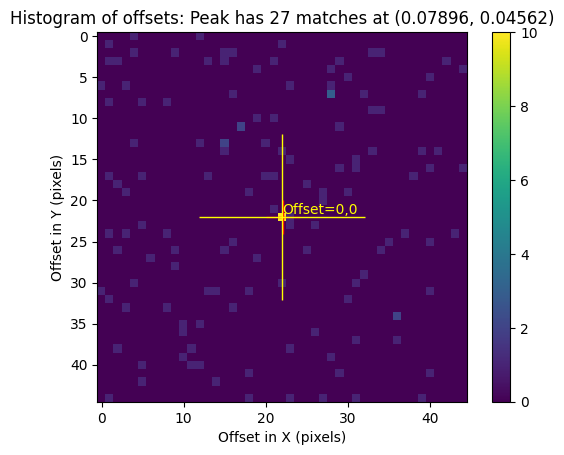

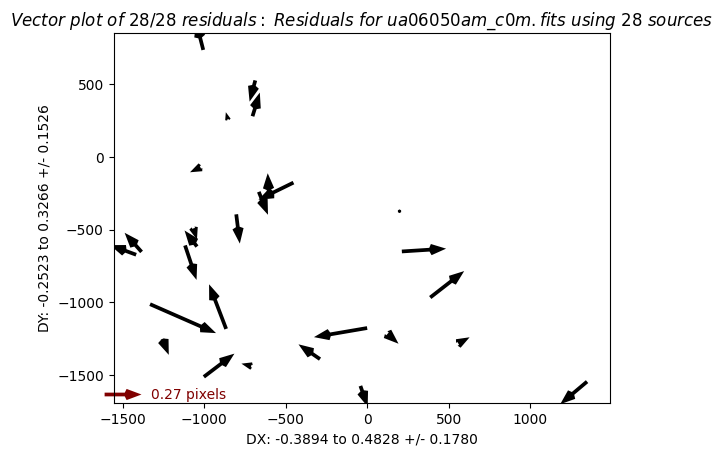

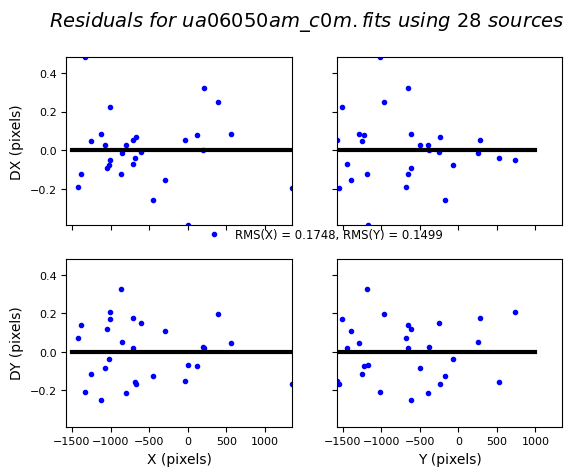

In [6]:
tweakreg.TweakReg('ua*c0m.fits', updatehdr=True, reusename=True, interactive=False,
                  conv_width=3.0, threshold=300.0, peakmin=100, peakmax=10000)

## 4. Equalize the chip sensitivities <a id="equalize"></a>

This step adjusts image data values so that all images and chips appear (to `AstroDrizzle`) to have a single inverse sensitivity (`PHOTFLAM`). This can be achieved using the `photeq` task in `Drizzlepac`. This task adjusts image data so that when these data are multiplied by the same single `PHOTFLAM` value, the correct flux is obtained.

In [7]:
photeq.photeq(files='ua*_c0m.fits', ref_phot_ext=3, readonly=False)

***** photeq started on 2024-11-12 01:59:31.972358


      Version 3.7.1.1 


PRIMARY PHOTOMETRIC KEYWORD: PHOTFLAM


SECONDARY PHOTOMETRIC KEYWORD(S): PHOTFNU


REFERENCE VALUE FROM FILE: 'ua060506m_c0m.fits[3]'


REFERENCE 'PHOTFLAM' VALUE IS: 2.449067e-18


Processing file 'ua060506m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3) - This is the "reference" extension.


          Nothing to do. Skipping this extension...


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua060508m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua060502m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua060504m_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua06050cm_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Processing file 'ua06050am_c0m.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.449067e-18)


     - Computed conversion factor for data: 1.0


     - Data have been multiplied by 1.0


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Done.


In the above command, we instruct `photeq` to "equalize" all chips of all input images using the `PHOTFLAM` for the `WF3` chip (`ref_phot_ext=3`), using the first image as a reference. This reference `PHOTFLAM` value is reported in the log file:

```
REFERENCE VALUE FROM FILE: 'ua060502m_c0m.fits['SCI',1]'
REFERENCE 'PHOTFLAM' VALUE IS: 2.507987e-18
```

Upon the completion, `photeq` will not only adjust image data but also update `PHOTFLAM` values for all chips to this specific reference value.

## 5. Drizzle-combine the images <a id="drizzle"></a>

All four chips are now drizzled together with an output pixel scale set to that of the WF chips:

In [8]:

astrodrizzle.AstroDrizzle('ua*c0m.fits',
                          preserve=False,
                          driz_sep_bits='8,1024',
                          driz_sep_wcs=True,
                          driz_sep_scale=0.0996,
                          combine_type='median',
                          driz_cr_snr='5.5 3.5',
                          driz_cr_scale='2.0 1.5',
                          final_fillval=None,
                          final_bits='8,1024',
                          final_wcs=True,
                          final_scale=0.0996,
                          skysub=False)

Setting up logfile :  astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


AstroDrizzle Version 3.7.1.1 started at: 01:59:32.238 (12/11/2024)


==== Processing Step  Initialization  started at  01:59:32.240 (12/11/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN' 'DEC--TAN' 


CRVAL : 323.3186954173473 -0.8646124859064191 


CRPIX : 777.9854781573198 767.6957940734236 


CD1_1 CD1_2  : 5.4139087290459394e-06 -2.713179014952763e-05 


CD2_1 CD2_2  : -2.713179014952763e-05 -5.4139087290459394e-06 


NAXIS : 1555  1535


********************************************************************************


*


*  Estimated memory usage:  up to 128 Mb.


*  Output image size:       1555 X 1535 pixels. 


*  Output image file:       ~ 27 Mb. 


*  Cores available:         4


*


********************************************************************************


==== Processing Step Initialization finished at 01:59:33.9 (12/11/2024)


==== Processing Step  Static Mask  started at  01:59:33.959 (12/11/2024)


==== Processing Step Static Mask finished at 01:59:34.200 (12/11/2024)


==== Processing Step  Subtract Sky  started at  01:59:34.201 (12/11/2024)


==== Processing Step Subtract Sky finished at 01:59:34.515 (12/11/2024)


==== Processing Step  Separate Drizzle  started at  01:59:34.516 (12/11/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN' 'DEC--TAN' 


CRVAL : 323.3186954173473 -0.8646124859064191 


CRPIX : 777.9854781573198 767.6957940734236 


CD1_1 CD1_2  : 5.4139087290459394e-06 -2.713179014952763e-05 


CD2_1 CD2_2  : -2.713179014952763e-05 -5.4139087290459394e-06 


NAXIS : 1555  1535


-Generating simple FITS output: ua060502m_c0m_single_sci.fits


-Generating simple FITS output: ua060504m_c0m_single_sci.fits


-Generating simple FITS output: ua060506m_c0m_single_sci.fits


-Generating simple FITS output: ua060508m_c0m_single_sci.fits


Writing out image to disk: ua060502m_c0m_single_sci.fits


Writing out image to disk: ua060504m_c0m_single_sci.fits


Writing out image to disk: ua060506m_c0m_single_sci.fits


Writing out image to disk: ua060508m_c0m_single_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: ua060502m_c0m_single_wht.fits


Deleted all instances of WCS with key B in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: ua060504m_c0m_single_wht.fits


Writing out image to disk: ua060506m_c0m_single_wht.fits


Writing out image to disk: ua060508m_c0m_single_wht.fits


-Generating simple FITS output: ua06050am_c0m_single_sci.fits


-Generating simple FITS output: ua06050cm_c0m_single_sci.fits


Writing out image to disk: ua06050am_c0m_single_sci.fits


Writing out image to disk: ua06050cm_c0m_single_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: ua06050am_c0m_single_wht.fits


Writing out image to disk: ua06050cm_c0m_single_wht.fits


==== Processing Step Separate Drizzle finished at 01:59:37.583 (12/11/2024)


==== Processing Step  Create Median  started at  01:59:37.585 (12/11/2024)


reference sky value for image 'ua060502m_c0m.fits' is 0.0


reference sky value for image 'ua060504m_c0m.fits' is 0.0


reference sky value for image 'ua060506m_c0m.fits' is 0.0


reference sky value for image 'ua060508m_c0m.fits' is 0.0


reference sky value for image 'ua06050am_c0m.fits' is 0.0


reference sky value for image 'ua06050cm_c0m.fits' is 0.0


Saving output median image to: 'final_drw_med.fits'


==== Processing Step Create Median finished at 01:59:38.097 (12/11/2024)


==== Processing Step  Blot  started at  01:59:38.098 (12/11/2024)


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci1_blt.fits


Writing out image to disk: ua060502m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci2_blt.fits


Writing out image to disk: ua060502m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci3_blt.fits


Writing out image to disk: ua060502m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060502m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060502m_c0m_sci4_blt.fits


Writing out image to disk: ua060502m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci1_blt.fits


Writing out image to disk: ua060504m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci2_blt.fits


Writing out image to disk: ua060504m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci3_blt.fits


Writing out image to disk: ua060504m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060504m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060504m_c0m_sci4_blt.fits


Writing out image to disk: ua060504m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci1_blt.fits


Writing out image to disk: ua060506m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci2_blt.fits


Writing out image to disk: ua060506m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci3_blt.fits


Writing out image to disk: ua060506m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060506m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060506m_c0m_sci4_blt.fits


Writing out image to disk: ua060506m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci1_blt.fits


Writing out image to disk: ua060508m_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci2_blt.fits


Writing out image to disk: ua060508m_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci3_blt.fits


Writing out image to disk: ua060508m_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua060508m_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua060508m_c0m_sci4_blt.fits


Writing out image to disk: ua060508m_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci1_blt.fits


Writing out image to disk: ua06050am_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci2_blt.fits


Writing out image to disk: ua06050am_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci3_blt.fits


Writing out image to disk: ua06050am_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua06050am_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050am_c0m_sci4_blt.fits


Writing out image to disk: ua06050am_c0m_sci4_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,1]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci1_blt.fits


Writing out image to disk: ua06050cm_c0m_sci1_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,2]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci2_blt.fits


Writing out image to disk: ua06050cm_c0m_sci2_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,3]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci3_blt.fits


Writing out image to disk: ua06050cm_c0m_sci3_blt.fits


    Blot: creating blotted image:  ua06050cm_c0m.fits[sci,4]


Using default C-based coordinate transformation...


-Generating simple FITS output: ua06050cm_c0m_sci4_blt.fits


Writing out image to disk: ua06050cm_c0m_sci4_blt.fits


==== Processing Step Blot finished at 01:59:42.020 (12/11/2024)


==== Processing Step  Driz_CR  started at  01:59:42.021 (12/11/2024)


Creating output: ua060502m_c0m_sci1_crmask.fits


Creating output: ua060504m_c0m_sci1_crmask.fits


Creating output: ua060506m_c0m_sci1_crmask.fits


Creating output: ua060508m_c0m_sci1_crmask.fits


Creating output: ua060504m_c0m_sci2_crmask.fits


Creating output: ua060502m_c0m_sci2_crmask.fits


Creating output: ua060506m_c0m_sci2_crmask.fits


Creating output: ua060508m_c0m_sci2_crmask.fits


Creating output: ua060504m_c0m_sci3_crmask.fits


Creating output: ua060502m_c0m_sci3_crmask.fits


Creating output: ua060506m_c0m_sci3_crmask.fits


Creating output: ua060508m_c0m_sci3_crmask.fits


Creating output: ua060504m_c0m_sci4_crmask.fits


Creating output: ua060502m_c0m_sci4_crmask.fits


Creating output: ua060506m_c0m_sci4_crmask.fits


Creating output: ua060508m_c0m_sci4_crmask.fits


Creating output: ua06050am_c0m_sci1_crmask.fits


Creating output: ua06050cm_c0m_sci1_crmask.fits


Creating output: ua06050am_c0m_sci2_crmask.fits


Creating output: ua06050cm_c0m_sci2_crmask.fits


Creating output: ua06050am_c0m_sci3_crmask.fits


Creating output: ua06050cm_c0m_sci3_crmask.fits


Creating output: ua06050am_c0m_sci4_crmask.fits


Creating output: ua06050cm_c0m_sci4_crmask.fits


==== Processing Step Driz_CR finished at 01:59:44.363 (12/11/2024)


==== Processing Step  Final Drizzle  started at  01:59:44.379 (12/11/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN' 'DEC--TAN' 


CRVAL : 323.3186954173473 -0.8646124859064191 


CRPIX : 777.9854781573198 767.6957940734236 


CD1_1 CD1_2  : 5.4139087290459394e-06 -2.713179014952763e-05 


CD2_1 CD2_2  : -2.713179014952763e-05 -5.4139087290459394e-06 


NAXIS : 1555  1535


-Generating simple FITS output: final_drw_sci.fits


Writing out image to disk: final_drw_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: final_drw_wht.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: final_drw_ctx.fits


==== Processing Step Final Drizzle finished at 01:59:51.03 (12/11/2024)


AstroDrizzle Version 3.7.1.1 is finished processing at 01:59:51.035 (12/11/2024).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          1.7174 sec.


            Static Mask          0.2407 sec.


           Subtract Sky          0.3138 sec.


       Separate Drizzle          3.0675 sec.


          Create Median          0.5121 sec.


                   Blot          3.9219 sec.


                Driz_CR          2.3425 sec.


          Final Drizzle          6.6552 sec.


   ====================          ====================


                  Total          18.7711 sec.


Trailer file written to:  astrodrizzle.log


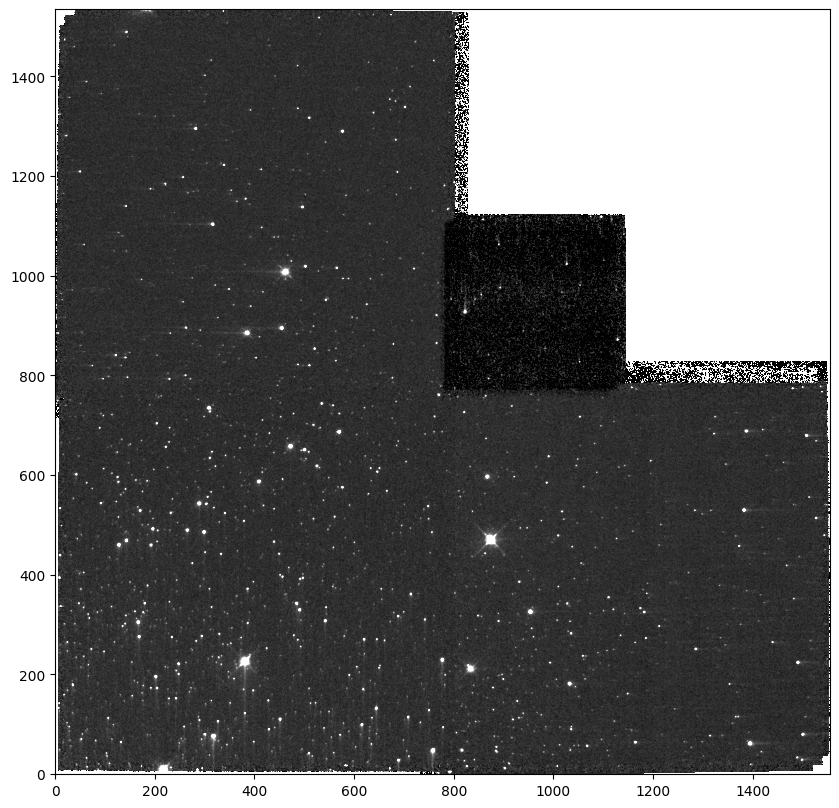

In [9]:
drw_data = fits.getdata('final_drw_sci.fits')
plt.figure(figsize=(10, 10))
plt.imshow(drw_data, cmap='gray', vmin=-0.1, vmax=0.5, origin='lower')
plt.show()

## 6. Illustration of the Effects of Sensitivity Variation on Drizzling <a id="example"></a>

The effect of drizzling images with different detector sensitivies, while tangible, is sometimes difficult to _visualize_ in noisy data, especially when drizzling multiple dithered images that can blur the borders between chips.

In this section we produce a simple simulation of observing a constant intensity "blank sky". We then make a copy of this image and apply sensitivity equalization to it. Finally we drizzle both images and compare them side-by-side.

### Simulate an Image of Constant "Blank Sky" Background <a id="constant"></a>

In this simple simulation we assume only Poisson noise.

In [10]:
with fits.open(backup_image, mode='update') as h:
    # get chip inverse-sensitivity:
    phot1 = h[1].header['PHOTFLAM']
    phot2 = h[2].header['PHOTFLAM']
    phot3 = h[3].header['PHOTFLAM']
    phot4 = h[4].header['PHOTFLAM']
    
    # get chip WCS:
    w1 = HSTWCS(h, ext=1)
    w2 = HSTWCS(h, ext=2)
    w3 = HSTWCS(h, ext=3)
    w4 = HSTWCS(h, ext=4)
    ref_pscale = w4.idcscale
    
    # get chip gain:
    cmdgain = h[0].header['ATODGAIN']
    gain1 = WFPC2_GAINS[1][cmdgain][0]
    gain2 = WFPC2_GAINS[2][cmdgain][0]
    gain3 = WFPC2_GAINS[3][cmdgain][0]
    gain4 = WFPC2_GAINS[4][cmdgain][0]
    
    # final drizzle scale:
    scale = 0.0996
    
    # simulated sky level ("true" sky is constant):
    sky = 10 * phot3

    # simulate observed counts assuming only Poisson noise:
    conv1a = gain1 * (w1.idcscale / ref_pscale)**2 / phot1
    conv1b = (gain4 / gain1**2) * (ref_pscale / scale)**2
    conv2a = gain2 * (w2.idcscale / ref_pscale)**2 / phot2
    conv2b = (gain4 / gain2**2) * (ref_pscale / scale)**2
    conv3a = gain3 * (w3.idcscale / ref_pscale)**2 / phot3
    conv3b = (gain4 / gain3**2) * (ref_pscale / scale)**2
    conv4a = gain4 * (w4.idcscale / ref_pscale)**2 / phot4
    conv4b = (1.0 / gain4) * (ref_pscale / scale)**2

    h[1].data[:, :] = np.random.poisson(conv1a * sky, h[1].data.shape) * conv1b
    h[2].data[:, :] = np.random.poisson(conv2a * sky, h[2].data.shape) * conv2b
    h[3].data[:, :] = np.random.poisson(conv3a * sky, h[3].data.shape) * conv3b
    h[4].data[:, :] = np.random.poisson(conv4a * sky, h[4].data.shape) * conv4b

# make a copy of this file:
photeq_image = 'simulation_eq.fits'
if os.path.isfile(photeq_image):
    os.remove(photeq_image)
shutil.copy2(backup_image, photeq_image)

# apply equalization to the image copy:
photeq.photeq(files=photeq_image, ref_phot_ext=3, readonly=False)

***** photeq started on 2024-11-12 01:59:51.721828


      Version 3.7.1.1 


PRIMARY PHOTOMETRIC KEYWORD: PHOTFLAM


SECONDARY PHOTOMETRIC KEYWORD(S): PHOTFNU


REFERENCE VALUE FROM FILE: 'simulation_eq.fits[3]'


REFERENCE 'PHOTFLAM' VALUE IS: 2.449067e-18


Processing file 'simulation_eq.fits'


   * EXT: ('SCI', 1)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.507987e-18)


     - Computed conversion factor for data: 1.0240581413248393


     - Data have been multiplied by 1.0240581413248393


   * EXT: ('SCI', 2)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.458077e-18)


     - Computed conversion factor for data: 1.0036789520254041


     - Data have been multiplied by 1.0036789520254041


   * EXT: ('SCI', 3) - This is the "reference" extension.


          Nothing to do. Skipping this extension...


   * EXT: ('SCI', 4)


     - Setting PHOTFLAM to 2.449067e-18 (old value was 2.498411e-18)


     - Computed conversion factor for data: 1.0201480808814134


     - Data have been multiplied by 1.0201480808814134


Done.


We need to make a simulated DQ array. We used the first science image in the downloaded dataset for the simulation, so we will use its DQ image. 

In [11]:
# make an DQ array for every 
hdu = fits.open('ua06050cm_c1m.fits')
shape = np.shape(hdu[1].data)
zero_DQ = np.zeros(shape)

fits_file = fits.HDUList()
# copy all of its extensions over, including the header
hdu0 = fits.PrimaryHDU(header=hdu[0].header)
hdu1 = fits.ImageHDU(hdu[1].data, header=hdu[1].header)
hdu2 = fits.ImageHDU(hdu[2].data, header=hdu[2].header)
hdu3 = fits.ImageHDU(hdu[3].data, header=hdu[3].header)
hdu4 = fits.ImageHDU(hdu[4].data, header=hdu[4].header)

fits_file.append(hdu0)
fits_file.append(hdu1)
fits_file.append(hdu2)
fits_file.append(hdu3)
fits_file.append(hdu4)

fits_file.writeto('simula_c1n.fits', overwrite=True)
fits_file.writeto('simulatio_c1q.fits', overwrite=True)

### Drizzle the Original Simulated Image and the Equalized Image <a id="drizzling"></a>

In [12]:
astrodrizzle.AstroDrizzle(
    backup_image,
    output='nonequalized.fits',
    stepsize=1,
    preserve=False,
    restore=False,
    in_memory=True,
    context=False,
    build=False,
    static=False,
    skysub=False,
    median=False,
    blot=False,
    driz_cr=False,
    final_fillval=None,
    final_bits='',
    final_wcs=True,
    final_scale=scale)

astrodrizzle.AstroDrizzle(
    photeq_image,
    output='equalized.fits',
    stepsize=1,
    preserve=False,
    restore=False,
    in_memory=True,
    context=False,
    build=False,
    static=False,
    skysub=False,
    median=False,
    blot=False,
    driz_cr=False,
    final_fillval=None,
    final_bits='',
    final_wcs=True,
    final_scale=scale)

Setting up logfile :  astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


AstroDrizzle Version 3.7.1.1 started at: 01:59:51.835 (12/11/2024)


==== Processing Step  Initialization  started at  01:59:51.837 (12/11/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN' 'DEC--TAN' 


CRVAL : 323.319046805706 -0.864077908088171 


CRPIX : 761.5219836230858 751.4609591854984 


CD1_1 CD1_2  : 5.413912553140539e-06 -2.71317893864631e-05 


CD2_1 CD2_2  : -2.71317893864631e-05 -5.413912553140539e-06 


NAXIS : 1522  1502


********************************************************************************


*


*  Estimated memory usage:  up to 124 Mb.


*  Output image size:       1522 X 1502 pixels. 


*  Output image file:       ~ 26 Mb. 


*  Cores available:         4


*


********************************************************************************


==== Processing Step Initialization finished at 01:59:52.128 (12/11/2024)


==== Processing Step  Static Mask  started at  01:59:52.130 (12/11/2024)


==== Processing Step Static Mask finished at 01:59:52.131 (12/11/2024)


==== Processing Step  Subtract Sky  started at  01:59:52.132 (12/11/2024)


==== Processing Step Subtract Sky finished at 01:59:52.168 (12/11/2024)


==== Processing Step  Separate Drizzle  started at  01:59:52.169 (12/11/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN' 'DEC--TAN' 


CRVAL : 323.319046805706 -0.864077908088171 


CRPIX : 1664.0 1642.0 


CD1_1 CD1_2  : 2.4758866590958315e-06 -1.2407890729667289e-05 


CD2_1 CD2_2  : -1.2407890729667289e-05 -2.4758866590958315e-06 


NAXIS : 3328  3284


-Generating simple FITS output: simulation_single_sci.fits


Writing out image to disk: simulation_single_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


==== Processing Step Separate Drizzle finished at 01:59:53.602 (12/11/2024)


==== Processing Step  Create Median  started at  01:59:53.603 (12/11/2024)


==== Processing Step  Blot  started at  01:59:53.604 (12/11/2024)


==== Processing Step Blot finished at 01:59:53.606 (12/11/2024)


==== Processing Step  Driz_CR  started at  01:59:53.606 (12/11/2024)


==== Processing Step  Final Drizzle  started at  01:59:53.608 (12/11/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN' 'DEC--TAN' 


CRVAL : 323.319046805706 -0.864077908088171 


CRPIX : 761.5219836230858 751.4609591854984 


CD1_1 CD1_2  : 5.413912553140539e-06 -2.71317893864631e-05 


CD2_1 CD2_2  : -2.71317893864631e-05 -5.413912553140539e-06 


NAXIS : 1522  1502


-Generating simple FITS output: nonequalized_sci.fits


Writing out image to disk: nonequalized_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: nonequalized_wht.fits


==== Processing Step Final Drizzle finished at 01:59:55.593 (12/11/2024)


AstroDrizzle Version 3.7.1.1 is finished processing at 01:59:55.594 (12/11/2024).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          0.2915 sec.


            Static Mask          0.0013 sec.


           Subtract Sky          0.0360 sec.


       Separate Drizzle          1.4333 sec.


          Create Median          0.0000 sec.


                   Blot          0.0014 sec.


                Driz_CR          0.0000 sec.


          Final Drizzle          1.9851 sec.


   ====================          ====================


                  Total          3.7486 sec.


Trailer file written to:  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


AstroDrizzle Version 3.7.1.1 started at: 01:59:55.627 (12/11/2024)


==== Processing Step  Initialization  started at  01:59:55.628 (12/11/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN' 'DEC--TAN' 


CRVAL : 323.319046805706 -0.864077908088171 


CRPIX : 761.5219836230858 751.4609591854984 


CD1_1 CD1_2  : 5.413912553140539e-06 -2.71317893864631e-05 


CD2_1 CD2_2  : -2.71317893864631e-05 -5.413912553140539e-06 


NAXIS : 1522  1502


********************************************************************************


*


*  Estimated memory usage:  up to 124 Mb.


*  Output image size:       1522 X 1502 pixels. 


*  Output image file:       ~ 26 Mb. 


*  Cores available:         4


*


********************************************************************************


==== Processing Step Initialization finished at 01:59:55.922 (12/11/2024)


==== Processing Step  Static Mask  started at  01:59:55.925 (12/11/2024)


==== Processing Step Static Mask finished at 01:59:55.927 (12/11/2024)


==== Processing Step  Subtract Sky  started at  01:59:55.927 (12/11/2024)


==== Processing Step Subtract Sky finished at 01:59:55.963 (12/11/2024)


==== Processing Step  Separate Drizzle  started at  01:59:55.964 (12/11/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN' 'DEC--TAN' 


CRVAL : 323.319046805706 -0.864077908088171 


CRPIX : 1664.0 1642.0 


CD1_1 CD1_2  : 2.4758866590958315e-06 -1.2407890729667289e-05 


CD2_1 CD2_2  : -1.2407890729667289e-05 -2.4758866590958315e-06 


NAXIS : 3328  3284


-Generating simple FITS output: simulation_eq_single_sci.fits


Writing out image to disk: simulation_eq_single_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


==== Processing Step Separate Drizzle finished at 01:59:57.293 (12/11/2024)


==== Processing Step  Create Median  started at  01:59:57.294 (12/11/2024)


==== Processing Step  Blot  started at  01:59:57.296 (12/11/2024)


==== Processing Step Blot finished at 01:59:57.297 (12/11/2024)


==== Processing Step  Driz_CR  started at  01:59:57.298 (12/11/2024)


==== Processing Step  Final Drizzle  started at  01:59:57.300 (12/11/2024)


WCS Keywords


Number of WCS axes: 2


CTYPE : 'RA---TAN' 'DEC--TAN' 


CRVAL : 323.319046805706 -0.864077908088171 


CRPIX : 761.5219836230858 751.4609591854984 


CD1_1 CD1_2  : 5.413912553140539e-06 -2.71317893864631e-05 


CD2_1 CD2_2  : -2.71317893864631e-05 -5.413912553140539e-06 


NAXIS : 1522  1502


-Generating simple FITS output: equalized_sci.fits


Writing out image to disk: equalized_sci.fits


Deleted all instances of WCS with key A in extensions [0]


Deleted all instances of WCS with key B in extensions [0]


Writing out image to disk: equalized_wht.fits


==== Processing Step Final Drizzle finished at 01:59:59.386 (12/11/2024)


AstroDrizzle Version 3.7.1.1 is finished processing at 01:59:59.388 (12/11/2024).


   --------------------          --------------------


                   Step          Elapsed time


   --------------------          --------------------


         Initialization          0.2939 sec.


            Static Mask          0.0014 sec.


           Subtract Sky          0.0360 sec.


       Separate Drizzle          1.3291 sec.


          Create Median          0.0000 sec.


                   Blot          0.0016 sec.


                Driz_CR          0.0000 sec.


          Final Drizzle          2.0864 sec.


   ====================          ====================


                  Total          3.7483 sec.


Trailer file written to:  astrodrizzle.log


### Display The Results of the Simulation Side-by-Side <a id="display"></a>

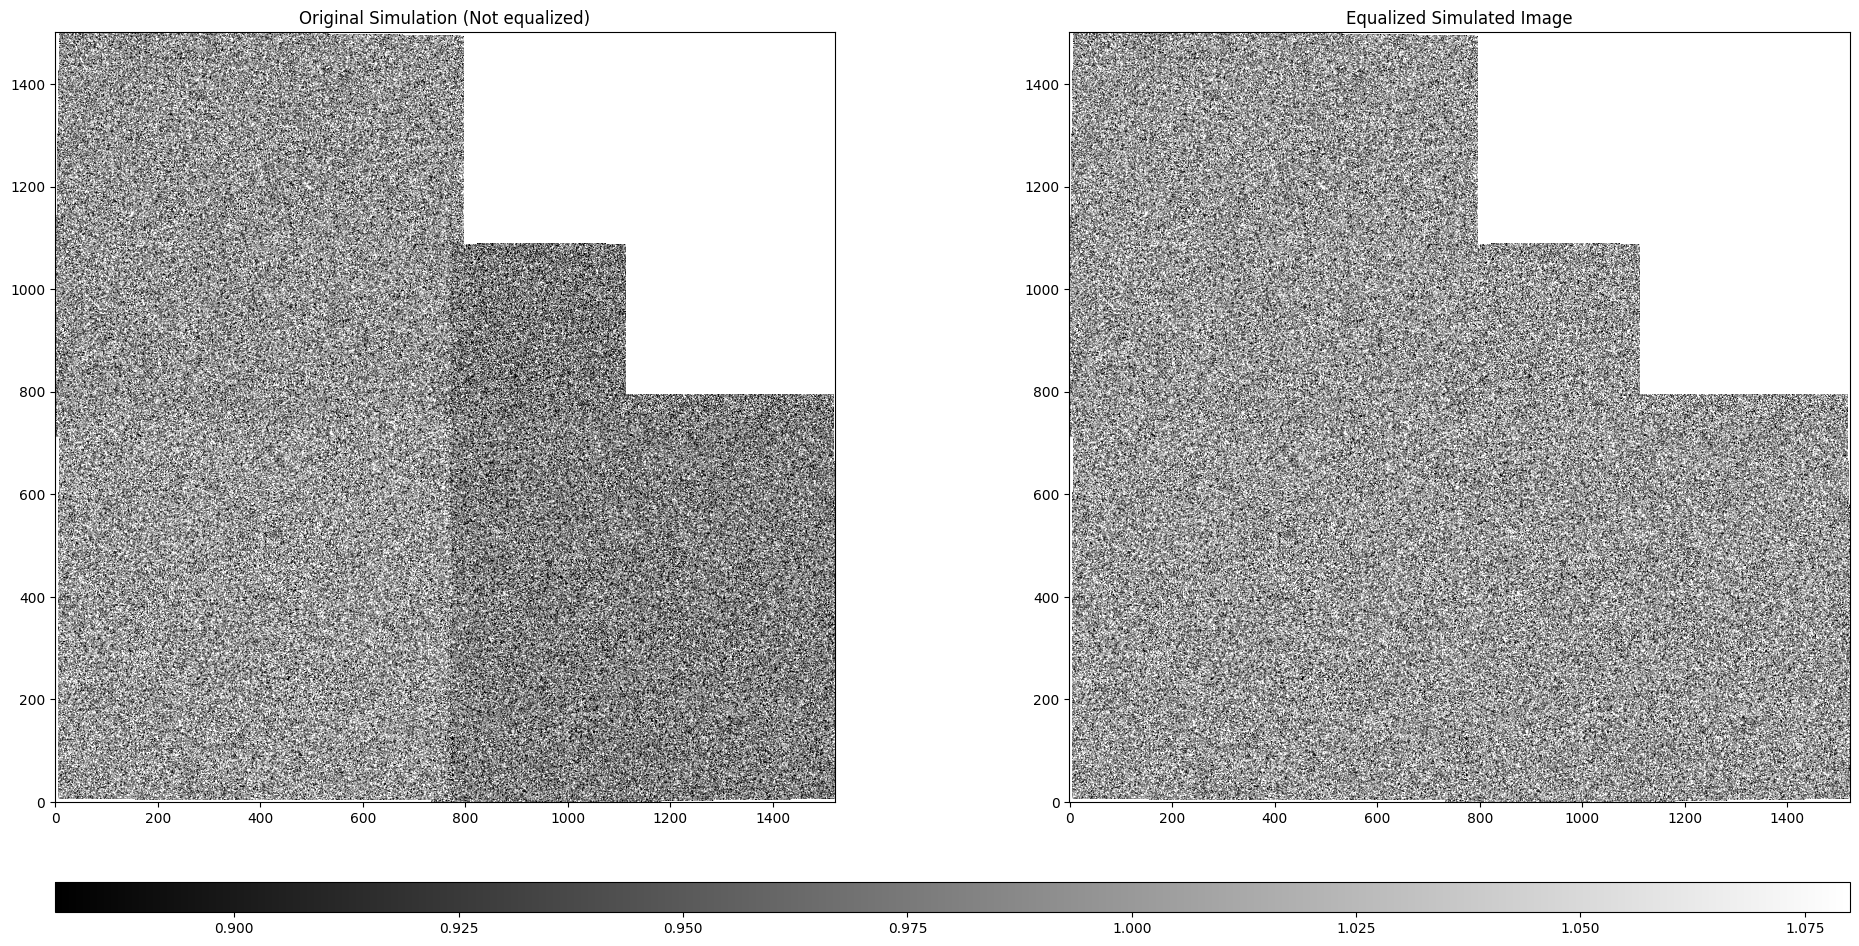

In [13]:
%matplotlib inline
drz_noneq = fits.getdata('nonequalized_sci.fits')
drz_eq = fits.getdata('equalized_sci.fits')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(24, 10))
im1 = ax1.imshow(drz_noneq, cmap='gray', vmin=0.88, vmax=1.08, origin='lower')
ax1.set_title('Original Simulation (Not equalized)')
im2 = ax2.imshow(drz_eq, cmap='gray', vmin=0.88, vmax=1.08, origin='lower')
ax2.set_title('Equalized Simulated Image')

x1 = ax1.get_position().get_points().flatten()[0]
x2 = ax2.get_position().get_points().flatten()[2] - x1
ax_cbar = fig.add_axes([x1, 0, x2, 0.03])
plt.colorbar(im1, cax=ax_cbar, orientation='horizontal')

The equalized image now have a ~constant background noise between all of the detectors with different sensitivities compared to the orignial simulation that has not been equalized.


    Author: M. Cara, STScI Data Analysis Tools Branch
            K. Huynh, WFC3 Instrument Branch
    Created: December 14, 2018
    Updated: November 16, 2023